In [46]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import pandas as pd
import openpyxl
import scipy.optimize

from scipy.stats import norm
from scipy.stats import t
from scipy.stats import chi2

# Efecto Seebeck

In [47]:
def Minimos_cuadrados(x,y,n=1):
    l = x.shape[0]
    b = y
    
    A = np.ones((l,n+1))
    
    for i in range(1,n+1):
        A[:,i] = x**i
        
    AT = np.dot(A.T,A)
    bT = np.dot(A.T,b)

    xsol = np.linalg.solve(AT,bT)
    
    return xsol

def GetModel(x,p):
    
    y = 0.
    for i in range(len(p)):
        y += p[i]*x**i
        
    return y

def GetError(x,y,p,n=1):
    
    l = x.shape[0]
    
    A = np.ones((l,n+1))
    
    for i in range(1,n+1):
        A[:,i] = x**i
        
    # Residuos
    R = y - np.dot(A,p)
    
    sigma2 = np.dot(R.T,R)/(len(y)-len(p))
    
    Cov = sigma2*np.linalg.inv(np.dot(A.T,A))
    
    R2 = None
    if np.shape(Cov) == (2,2):
        R2 = (Cov[0][1]**2)/(Cov[0][0]*Cov[1][1])

    return (Cov,R2,R)

def Get_sigma(Cov):
    sigmaai = np.sqrt(np.diagonal(Cov))
    return sigmaai[::-1]

def Error_relativo(X_real,X_exp):
    return (np.abs(X_exp - X_real)/X_real)

def presicion(d,v):
    p = (d/v)
    if p <= 0.1:
        return p,True
    else:
        return p,False
    
def exactitud(xr,xm,d):
    e = (np.abs(xr-xm))
    if e <= (2.5*d):
        return e/d,True
    else:
        return e/d,False

X = sym.Symbol('x',real=True)
Y = sym.Symbol('y',real=True)

In [48]:
c = 299798458*1e09 #nm/s
c_ = 299798458 #m/s
me = 0.51099895*1e06/(c**2) #eV/c**2
me_ = 0.51099895*1e06/(c_**2) #eV/c**2
mp = 938.27208816*1e06/(c**2) #eV/c**2
mn = 939.56542052*1e06/(c**2) #eV/c**2
h = 4.136667696*1e-15 #eV*s
h_barra = 6.582119569*1e-16 #eV*s
e_0 = 55.26349406*1e-03 #e**2/(cV*nm)
e = 1 #e
a_0 = 0.0529177210903 #nm
Ry = 13.605693122994 #eV
Miu_B = 5.7883818066*1e-05 #eV/T
Sr = 4.13*1e-04
Sr

0.000413

# Datos #1

In [49]:
# Provided data
data = """21°C - 9°C - 0.30V - 9,4A
23°C - 10°C - 0.39V - 12.4A
25°C - 10.5°C - 0.46V - 14.4A
27°C - 11°C - 0.52V - 16A
29°C - 11°C - 0.58V - 18A
32°C - 12°C - 0.67V - 20.3A
34°C - 13°C - 0.74V - 22.9A
36°C - 13.5°C - 0.78V - 23.8A
38°C - 14°C - 0.82V - 25.6A
40°C - 15°C - 0.89V - 27.4 A
42°C - 16°C - 0.94V - 29A
44°C - 16.5°C - 0.99V - 30.5A"""

# Split the data into lines
lines = data.split('\n')

# Initialize empty lists for each parameter
temperature_1 = []
temperature_2 = []
voltage = []
current = []

# Parse each line and separate the parameters
for line in lines:
    parts = line.split(' - ')
    temperature_1.append(float(parts[0].replace('°C', '')))
    temperature_2.append(float(parts[1].replace('°C', '')))
    voltage.append(float(parts[2].replace('V', '')))
    current.append(float(parts[3].replace('A', '').replace(',', '.')))  # Replace comma with dot for float conversion

# Print the arrays
print("Temperature 1 (°C):", temperature_1)
print("Temperature 2 (°C):", temperature_2)
print("Voltage (V):", voltage)
print("Current (A):", current)

Temperature 1 (°C): [21.0, 23.0, 25.0, 27.0, 29.0, 32.0, 34.0, 36.0, 38.0, 40.0, 42.0, 44.0]
Temperature 2 (°C): [9.0, 10.0, 10.5, 11.0, 11.0, 12.0, 13.0, 13.5, 14.0, 15.0, 16.0, 16.5]
Voltage (V): [0.3, 0.39, 0.46, 0.52, 0.58, 0.67, 0.74, 0.78, 0.82, 0.89, 0.94, 0.99]
Current (A): [9.4, 12.4, 14.4, 16.0, 18.0, 20.3, 22.9, 23.8, 25.6, 27.4, 29.0, 30.5]


Text(0.5, 1.0, '$\\varepsilon$ $vs$ $\\Delta T$')

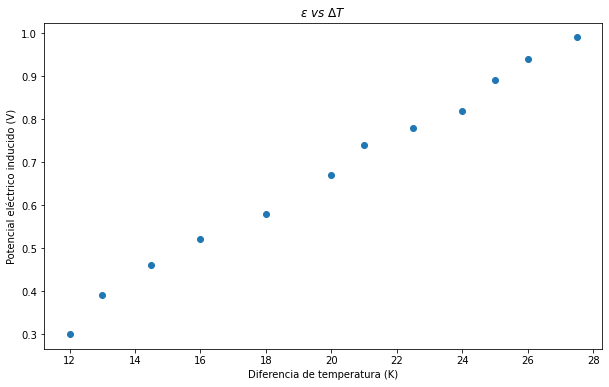

In [50]:
temperature_1 = np.array(temperature_1)
temperature_2 = np.array(temperature_2)
delta_T = temperature_1 - temperature_2
voltage = np.array(voltage)
current = np.array(current)

plt.figure(figsize=(10,6))
plt.scatter(delta_T,voltage)
plt.ylabel('Potencial eléctrico inducido (V)')
plt.xlabel('Diferencia de temperatura (K)')
plt.title(r'$\varepsilon$ $vs$ $\Delta T$')

Coeficiente de Seebeck

In [51]:
param = Minimos_cuadrados(delta_T,voltage)
param

array([-0.17576171,  0.04254338])

In [52]:
Cov,R2,r = GetError(delta_T,voltage,param)
deltas = Get_sigma(Cov)
deltas

array([0.0010479 , 0.02156858])

In [53]:
R2

0.9402548971395787

In [54]:
_x = np.linspace(np.min(delta_T),np.max(delta_T),50)
_y = GetModel(_x,param)

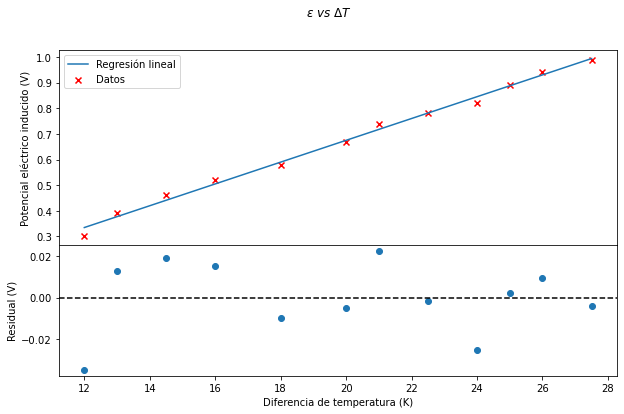

In [55]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1.5, 1]},sharex=True)
fig.subplots_adjust(hspace=0)
fig.suptitle(r'$\varepsilon$ $vs$ $\Delta T$')

axs[0].scatter(delta_T,voltage,label='Datos',color='r',marker='x')
#axs[0].errorbar(xR, l_i,yerr= error_y, fmt='none', ecolor='black')
axs[0].plot(_x,_y,label='Regresión lineal')
axs[0].set_ylabel('Potencial eléctrico inducido (V)')
#axs[0].text(0.184,0.00152,'m = (109e-04 $\pm$ 2e-04)\nb = (0.6e-05 $\pm$ 2.8e-05)\n$R^{2} = 0.973$',fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
axs[0].legend()

axs[1].scatter(delta_T,r)
axs[1].axhline(y=0, color='black', linestyle='--')
axs[1].set_xlabel('Diferencia de temperatura (K)')
axs[1].set_ylabel('Residual (V)')
#axs[1].set_ylim(-6.,7.5)
#axs[1].set_yticks(np.arange(-4.5, 7., 1.5))

plt.show()

In [56]:
Sr

0.000413

In [57]:
S = param[-1]
S

0.042543384319912204

In [58]:
dS = deltas[0]
dS

0.0010479004103586735

In [59]:
presicion(dS,S)

(0.02463133639013785, True)

In [60]:
Error_relativo(Sr,S)

102.01061578671236

In [61]:
exactitud(Sr,S,dS)

(40.20456896804907, False)

Corriente inducida vs ∆T

Text(0.5, 1.0, '$I$ $vs$ $\\Delta T$')

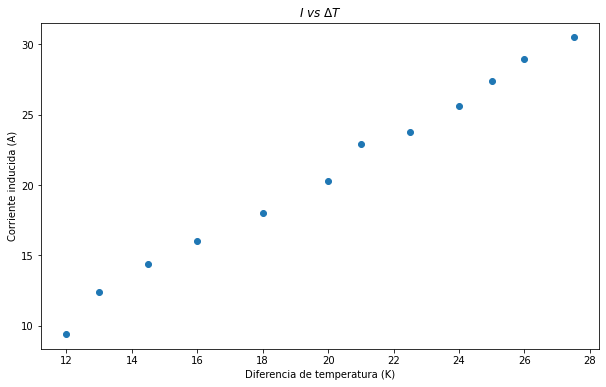

In [62]:
plt.figure(figsize=(10,6))
plt.scatter(delta_T,current)
plt.ylabel('Corriente inducida (A)')
plt.xlabel('Diferencia de temperatura (K)')
plt.title(r'$I$ $vs$ $\Delta T$')

In [63]:
param = Minimos_cuadrados(delta_T,current)
param

array([-5.06562864,  1.29639893])

In [64]:
Cov,R2,r = GetError(delta_T,current,param)
deltas = Get_sigma(Cov)
deltas

array([0.03388154, 0.69737225])

In [65]:
R2

0.9402548971395785

In [66]:
_y = GetModel(_x,param)

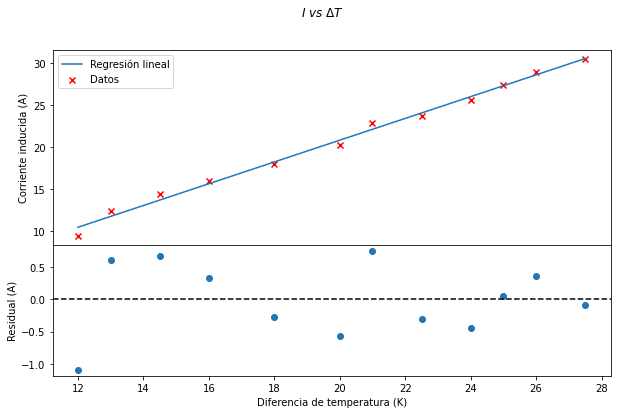

In [67]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1.5, 1]},sharex=True)
fig.subplots_adjust(hspace=0)
fig.suptitle(r'$I$ $vs$ $\Delta T$')

axs[0].scatter(delta_T,current,label='Datos',color='r',marker='x')
#axs[0].errorbar(xR, l_i,yerr= error_y, fmt='none', ecolor='black')
axs[0].plot(_x,_y,label='Regresión lineal')
axs[0].set_ylabel('Corriente inducida (A)')
#axs[0].text(0.184,0.00152,'m = (109e-04 $\pm$ 2e-04)\nb = (0.6e-05 $\pm$ 2.8e-05)\n$R^{2} = 0.973$',fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
axs[0].legend()

axs[1].scatter(delta_T,r)
axs[1].axhline(y=0, color='black', linestyle='--')
axs[1].set_xlabel('Diferencia de temperatura (K)')
axs[1].set_ylabel('Residual (A)')
#axs[1].set_ylim(-6.,7.5)
#axs[1].set_yticks(np.arange(-4.5, 7., 1.5))

plt.show()

Potencia eléctrica

In [71]:
P = current*voltage
P

array([ 2.82 ,  4.836,  6.624,  8.32 , 10.44 , 13.601, 16.946, 18.564,
       20.992, 24.386, 27.26 , 30.195])

Text(0.5, 1.0, '$P$ $vs$ $\\Delta T$')

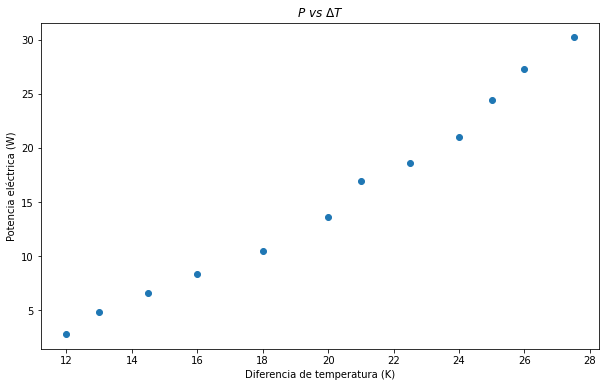

In [72]:
plt.figure(figsize=(10,6))
plt.scatter(delta_T,P)
plt.ylabel('Potencia eléctrica (W)')
plt.xlabel('Diferencia de temperatura (K)')
plt.title(r'$P$ $vs$ $\Delta T$')

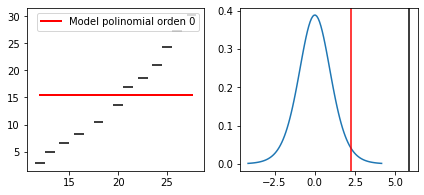

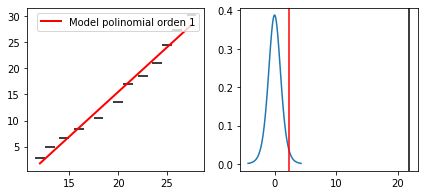

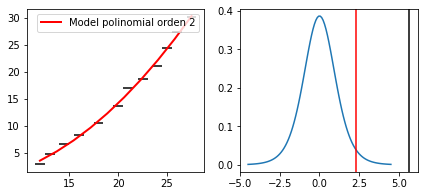

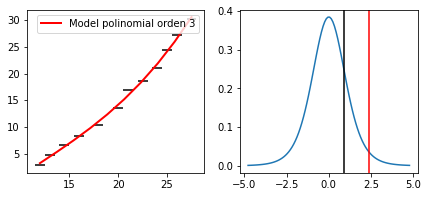

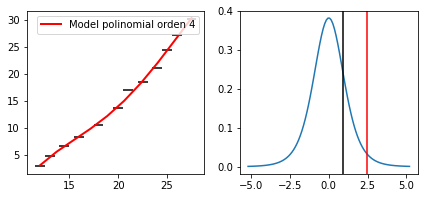

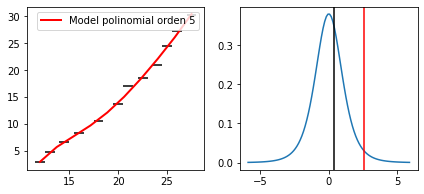

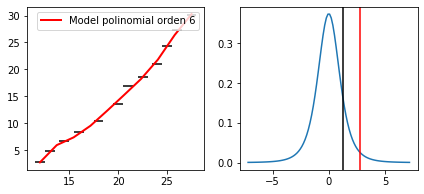

In [73]:
# Miramos cual es el mejor modelo:

for n in range(7):
    
    param = Minimos_cuadrados(delta_T,P,n)
    Cov,R2,r = GetError(delta_T,P,param,n)
    
    _x = np.linspace(np.min(delta_T),np.max(delta_T),10)
    _y = GetModel(_x,param)
    
    ai = param[-1]
    sigmaai = np.sqrt(Cov[-1,-1])
    
    tobs = np.abs(0. - ai)/sigmaai
    
    df = len(delta_T) - len(param) - 1
    #print(df)
    
    tcritico = t.ppf(0.975,df=df)
    tcritico

    #print(ai,sigmaai,tobs,tcritico)
    
    fig = plt.figure(figsize=(7,3))
    ax = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    
    ax.errorbar(delta_T,P, xerr= 0.5, fmt='none', ecolor='black')
    ax.plot(_x,_y,color='r',lw=2,label='Model polinomial orden {}'.format(n))
    ax.legend()
    
    _t = np.linspace(t.ppf(0.001,df=df),t.ppf(0.999,df=df),100)
    ax1.plot(_t,t.pdf(_t,df=df))
    ax1.axvline(x=tobs,color='k')
    ax1.axvline(x=tcritico,color='r')

In [74]:
# El mejor modelo es el polinomio de grado 2
n=2
param = Minimos_cuadrados(delta_T,P,n)
param

array([ 0.25111006, -0.36354951,  0.05292172])

In [75]:
Cov,R2,r = GetError(delta_T,P,param,n)
deltas = Get_sigma(Cov)
deltas

array([0.00933052, 0.3679609 , 3.44337032])

In [76]:
R2

In [77]:
_y = GetModel(_x,param)

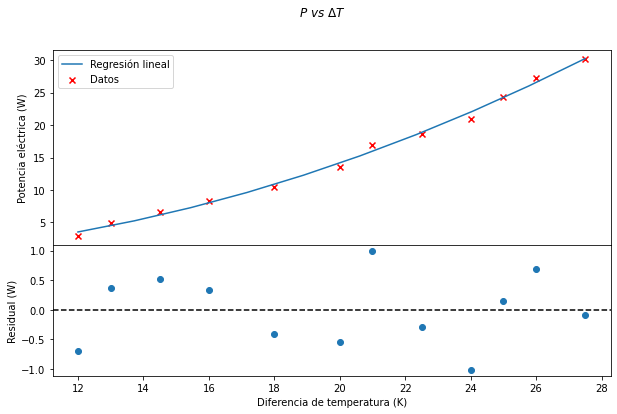

In [78]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1.5, 1]},sharex=True)
fig.subplots_adjust(hspace=0)
fig.suptitle(r'$P$ $vs$ $\Delta T$')

axs[0].scatter(delta_T,P,label='Datos',color='r',marker='x')
#axs[0].errorbar(xR, l_i,yerr= error_y, fmt='none', ecolor='black')
axs[0].plot(_x,_y,label='Regresión lineal')
axs[0].set_ylabel('Potencia eléctrica (W)')
#axs[0].text(0.184,0.00152,'m = (109e-04 $\pm$ 2e-04)\nb = (0.6e-05 $\pm$ 2.8e-05)\n$R^{2} = 0.973$',fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
axs[0].legend()

axs[1].scatter(delta_T,r)
axs[1].axhline(y=0, color='black', linestyle='--')
axs[1].set_xlabel('Diferencia de temperatura (K)')
axs[1].set_ylabel('Residual (W)')
#axs[1].set_ylim(-6.,7.5)
#axs[1].set_yticks(np.arange(-4.5, 7., 1.5))

plt.show()

# Datos #2

In [79]:
# Provided data
data = """27°C - 14°C - 0.33V - 7.4A
27°C - 14°C - 0.31V - 10.9A
27°C - 14°C - 0.3V - 9.6A
27°C - 14°C - 0.29V - 11.6A
27°C - 14°C - 0.28V - 13.4A"""

# Split the data into lines
lines = data.split('\n')

# Initialize empty lists for each parameter
temperature_1 = []
temperature_2 = []
voltage = []
current = []

# Parse each line and separate the parameters
for line in lines:
    parts = line.split(' - ')
    temperature_1.append(float(parts[0].replace('°C', '')))
    temperature_2.append(float(parts[1].replace('°C', '')))
    voltage.append(float(parts[2].replace('V', '')))
    current.append(float(parts[3].replace('A', '').replace(',', '.')))  # Replace comma with dot for float conversion

# Print the arrays
print("Temperature 1 (°C):", temperature_1)
print("Temperature 2 (°C):", temperature_2)
print("Voltage (V):", voltage)
print("Current (A):", current)

Temperature 1 (°C): [27.0, 27.0, 27.0, 27.0, 27.0]
Temperature 2 (°C): [14.0, 14.0, 14.0, 14.0, 14.0]
Voltage (V): [0.33, 0.31, 0.3, 0.29, 0.28]
Current (A): [7.4, 10.9, 9.6, 11.6, 13.4]


Text(0.5, 1.0, '$\\varepsilon$ $vs$ $I$')

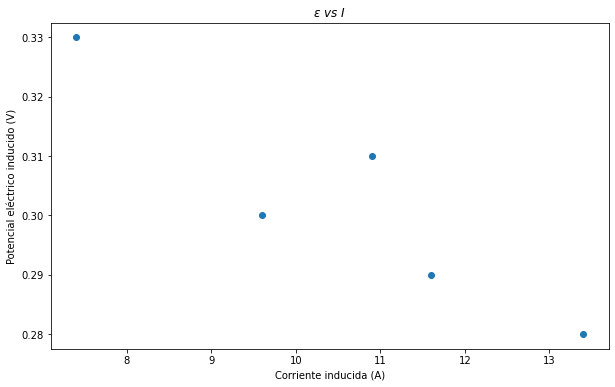

In [80]:
dT = temperature_1[0] - temperature_2[0]
voltage = np.array(voltage)
current = np.array(current)

plt.figure(figsize=(10,6))
plt.scatter(current,voltage)
plt.ylabel('Potencial eléctrico inducido (V)')
plt.xlabel('Corriente inducida (A)')
plt.title(r'$\varepsilon$ $vs$ $I$')

In [81]:
param = Minimos_cuadrados(current,voltage)
param

array([ 0.38530543, -0.00787386])

In [82]:
Cov,R2,r = GetError(current,voltage,param)
deltas = Get_sigma(Cov)
deltas

array([0.00194815, 0.02097955])

In [83]:
R2

0.9652185910149175

In [84]:
_x = np.linspace(np.min(current),np.max(current),50)
_y = GetModel(_x,param)

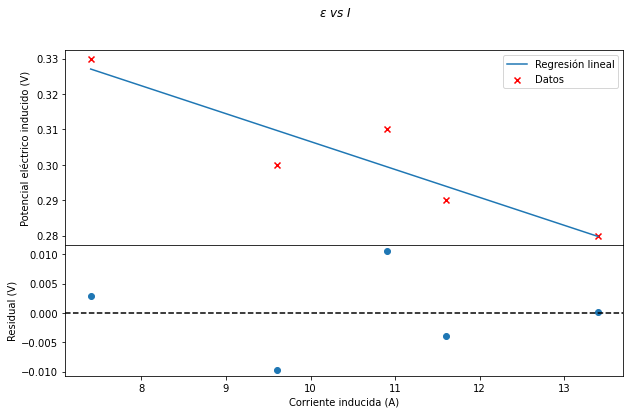

In [85]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [1.5, 1]},sharex=True)
fig.subplots_adjust(hspace=0)
fig.suptitle(r'$\varepsilon$ $vs$ $I$')

axs[0].scatter(current,voltage,label='Datos',color='r',marker='x')
#axs[0].errorbar(xR, l_i,yerr= error_y, fmt='none', ecolor='black')
axs[0].plot(_x,_y,label='Regresión lineal')
axs[0].set_ylabel('Potencial eléctrico inducido (V)')
#axs[0].text(0.184,0.00152,'m = (109e-04 $\pm$ 2e-04)\nb = (0.6e-05 $\pm$ 2.8e-05)\n$R^{2} = 0.973$',fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
axs[0].legend()

axs[1].scatter(current,r)
axs[1].axhline(y=0, color='black', linestyle='--')
axs[1].set_xlabel('Corriente inducida (A)')
axs[1].set_ylabel('Residual (V)')
#axs[1].set_ylim(-6.,7.5)
#axs[1].set_yticks(np.arange(-4.5, 7., 1.5))

plt.show()

In [86]:
# Ri
Ri = param[-1]*(-1)
dRi = deltas[0]
(Ri,dRi)

(0.007873859579531909, 0.0019481541064191206)

In [87]:
# V0
V0 = param[0]
dV0 = deltas[1]
(V0,dV0)

(0.38530543435144765, 0.020979548466561915)

In [88]:
Icc = V0/Ri
dIcc = (1/Ri)*np.sqrt((dV0**2) + (dRi*V0/Ri)**2)
(Icc,dIcc)

(48.93476070528979, 12.397175373193422)

In [89]:
presicion(dIcc,Icc)

(0.2533408806851139, False)